In [24]:
%load_ext autoreload
%autoreload 2
from data_utils import load_news_items, load_movie_data, load_movie_data_saved
import numpy as np
from Simulation import assign_groups, Usersampler, simulate, get_numerical_relevances
from Documents import Movie
from plotting import combine_and_plot_ndcg_unfairness
%matplotlib inline
from config import ex
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
trials = 10

In [26]:
def trial(items, start_popularity, G, ranking_method, user_generator, iterations=3000, DATA_SET = 0,MOVIE_RATING_FILE=""):

    popularity = np.copy(start_popularity)
    # Run Simulation
    
    numerical_relevances = get_numerical_relevances(items,DATA_SET, MOVIE_RATING_FILE)
    iterations, ranking_hist, popularity_hist, final_ranking, users, ideal, mean_relevances, w_pophist, errors, mean_exposure, fairness_hist, p_pophist = \
        simulate(popularity, items, ranking_method=ranking_method, click_model="PBM_log", iterations=iterations, numerical_relevance=numerical_relevances, user_generator=user_generator, DATA_SET=DATA_SET)
    ranking_hist = ranking_hist.astype(int)

    # Calculate the relevance difference between true relevance and approximation
    # Diff = |rel' - rel|
    if ranking_method == "Naive":
        rel_estimate = popularity_hist / np.arange(1, iterations + 1)[:, np.newaxis]
    elif "Pers" in ranking_method:
        p_pophist[99:, :] = [np.sum(p_pophist[98:100 + i, :], axis=0) for i in range(len(p_pophist) - 99)]
        rel_estimate = p_pophist / (np.arange(iterations) + 1)[:, np.newaxis]
    else:
        rel_estimate = w_pophist / np.arange(1, iterations + 1)[:, np.newaxis]

    rel_diff_trial = np.mean(np.abs(rel_estimate - (mean_relevances)[np.newaxis, :]), axis=1)
    return fairness_hist

def compare_models_news(ranking_methods, iterations = 3000):
    multiple_items = [load_news_items(n=30, completly_random=True) for i in range(trials)]
    items = multiple_items[0]
    popularity = np.ones(len(items))
    G = assign_groups(items)
    user_generator = Usersampler(DATA_SET=0, BI_LEFT=0.5, MOVIE_RATING_FILE = None)
    
    data = {"prop": np.zeros((len(ranking_methods), iterations, len(G))),
                "clicks": np.zeros((len(ranking_methods), iterations, len(G))), "rel": np.zeros((len(ranking_methods), iterations, len(G))),
                "true_rel": np.zeros((len(ranking_methods), iterations, len(G))), "NDCG": np.zeros((len(ranking_methods), iterations))}
      
    
    for i, method in enumerate(ranking_methods):
        data_hist = trial(items, popularity, G, method, user_generator, iterations, DATA_SET=0)
        for key, value in data_hist.items():
            data[key][i] = value

            
    overall_fairness = get_unfairness(data, G)
    
    plot_unfairness_and_NDCG(data["NDCG"], overall_fairness, ranking_methods, G)
    return data, overall_fairness


def get_unfairness(data, G):
    n_methods, iterations = np.shape(data["NDCG"])
    pair_group_combinations = [(a, b) for a in range(len(G)) for b in range(a + 1, len(G))]
    overall_fairness = np.zeros((n_methods, iterations, 4))
    for i in range(n_methods):
        for a, b in pair_group_combinations:
            overall_fairness[i, :, 0] += np.abs(
                data["prop"][i, :, a] / data["rel"][i, :, a] - data["prop"][i, :, b] / data["rel"][i, :, b])
            overall_fairness[i, :, 1] += np.abs(
                data["prop"][i, :, a] / data["true_rel"][i, :, a] - data["prop"][i, :, b] / data["true_rel"][i, :, b])
            overall_fairness[i, :, 2] += np.abs(
                data["clicks"][i, :, a] / data["rel"][i, :, a] - data["clicks"][i, :, b] / data["rel"][i, :, b])
            overall_fairness[i, :, 3] += np.abs(
                data["clicks"][i, :, a] / data["true_rel"][i, :, a] - data["clicks"][i, :, b] / data["true_rel"][i,:,b])
            
    return overall_fairness

def plot_unfairness_and_NDCG(ndcg, overall_fairness, ranking_methods, G):
    #Exposure Unfairness
    combine_and_plot_ndcg_unfairness(np.expand_dims(ndcg,axis=1),np.expand_dims(overall_fairness[:, :, 1],axis=1),labels= ranking_methods, selection=np.arange(len(ranking_methods)), name="JupyterNDCG_UnfairExposure.pdf",type = 0 )
    #Impact Unfairness
    combine_and_plot_ndcg_unfairness(np.expand_dims(ndcg,axis=1),np.expand_dims(overall_fairness[:, :, 3],axis=1),labels= ranking_methods, selection=np.arange(len(ranking_methods)), name="JupyterNDCG_UnfairImpact.pdf",type = 1 )
    
def plot_NDCG(run_data, ranking_methods):
    for i in len(ranking_methods):
        plot_ndcg(run_data["NDCG"][i], label=ranking_methods[i], plot=False, window_size=100)
    plt.legend()
    ax = plt.gca()
    plt.show()
    
    

# News Experiment

For Running the news Experiment, visit https://www.adfontesmedia.com/interactive-media-bias-chart/?v=402f03a963ba, scroll down and download their data as csv. Save this data as:  
"data/InteractiveMediaBiasChart.csv"

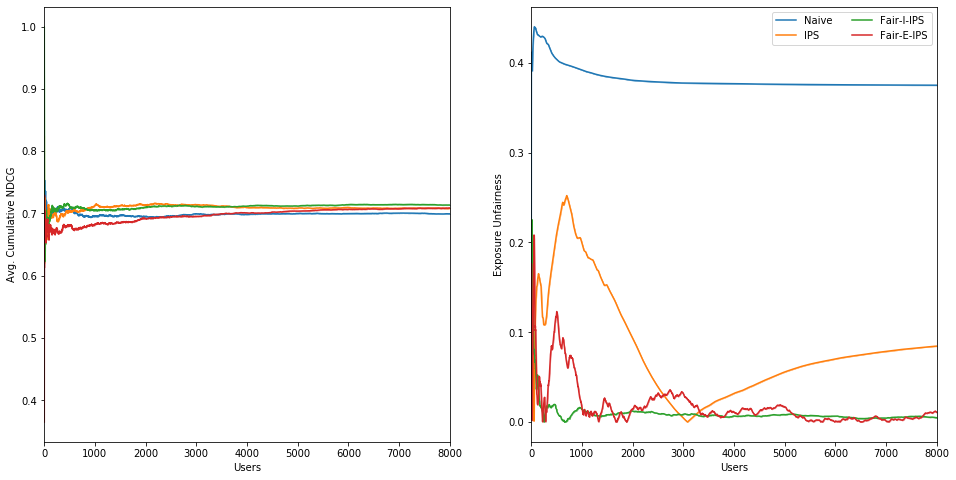

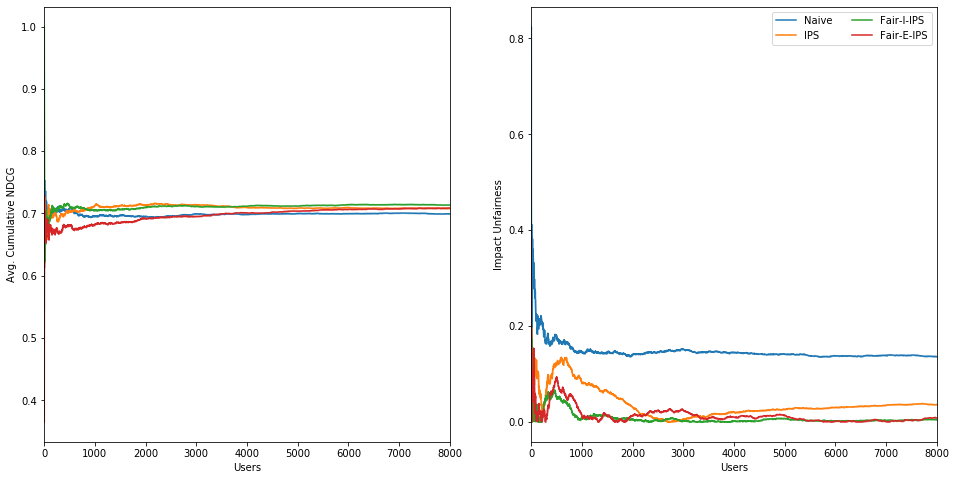

In [21]:
ranking_methods = ["Naive","IPS","Fair-I-IPS", "Fair-E-IPS"]
multiple_items = [load_news_items(n=30, completly_random=True) for i in range(trials)]
items = multiple_items[0]
popularity = np.ones(len(items))
G = assign_groups(items)
user_generator = Usersampler(DATA_SET=0, BI_LEFT=0.5, MOVIE_RATING_FILE = None)

data = {"prop": np.zeros((len(ranking_methods), iterations, len(G))),
            "clicks": np.zeros((len(ranking_methods), iterations, len(G))), "rel": np.zeros((len(ranking_methods), iterations, len(G))),
            "true_rel": np.zeros((len(ranking_methods), iterations, len(G))), "NDCG": np.zeros((len(ranking_methods), iterations))}

#Run trial for each Ranking method and add to data dict
for i, method in enumerate(ranking_methods):
    data_hist = trial(items, popularity, G, method, user_generator, iterations, DATA_SET=0)
    for key, value in data_hist.items():
        data[key][i] = value

#Get Unfairness based on Collect Data
overall_fairness = get_unfairness(data, G)

plot_unfairness_and_NDCG(data["NDCG"], overall_fairness, ranking_methods, G)


# Movie Experiment

For running the movie Experiment, you need to ML-20M Dataset in "data/ratings.csv" (https://grouplens.org/datasets/movielens/20m/) 
and the Movie Metadata in "data/movies_metadata.csv" ( orginally obtained from https://www.kaggle.com/rounakbanik/the-movies-dataset?select=movies_metadata.csv)

In [30]:
#We load the moviedataset Preprocess it and write Relevance_Matrix, Features and Groups in a File
MOVIE_RATING_FILE = "Jupyter-Binarized0.npy"
_, _, _ = load_movie_data(100, 10000, 5, movie_features="factorization", movie_ranking_sample_file = "Jupyter-Binarized")



(10000, 100)
MSE: 0.3638
MSE:  0.36381083954884086
RMSE: 0.6032
RMSE:  0.6031673395906321
Means:  -0.02541721100049937 -0.12482985078104773
Feature STD: 0.14633228097090506 0.5043340973287225
Full Matrix Shape (10000, 100) rankinG_shape (10000, 100)
Number of Users 10000 Number of Movies 100
the Dataset before completion is 0.05279  filled
The most rated movie has 6329 votes, the least 11 votes; mean 527.9
The most rating user rated 53 movies, the least 3 movies; mean 5.279


(10000, 100)
All user preferences already given, restarting with the old user!
trial99, loss: [-0.03178039565682411, -0.05907037481665611]
trial1099, loss: [0.043526262044906616, 0.031805556267499924]
trial2099, loss: [0.04062695801258087, 0.0312565341591835]
trial3099, loss: [0.03853558748960495, 0.030632073059678078]
trial4099, loss: [0.038008611649274826, 0.03120301477611065]
trial5099, loss: [0.03834507241845131, 0.03247436136007309]
trial6099, loss: [0.037795163691043854, 0.03253365680575371]
trial7099, loss: [0.03802864998579025, 0.03332877904176712]
trial8099, loss: [0.03866473585367203, 0.03429672494530678]
trial9099, loss: [0.0386558398604393, 0.03460678458213806]
All user preferences already given, restarting with the old user!
trial99, loss: [-0.025190792977809906, -0.053149256855249405]
trial1099, loss: [0.03927644342184067, 0.0274366308003664]
trial2099, loss: [0.037753183394670486, 0.028481170535087585]
trial3099, loss: [0.037232913076877594, 0.029620595276355743]
trial40

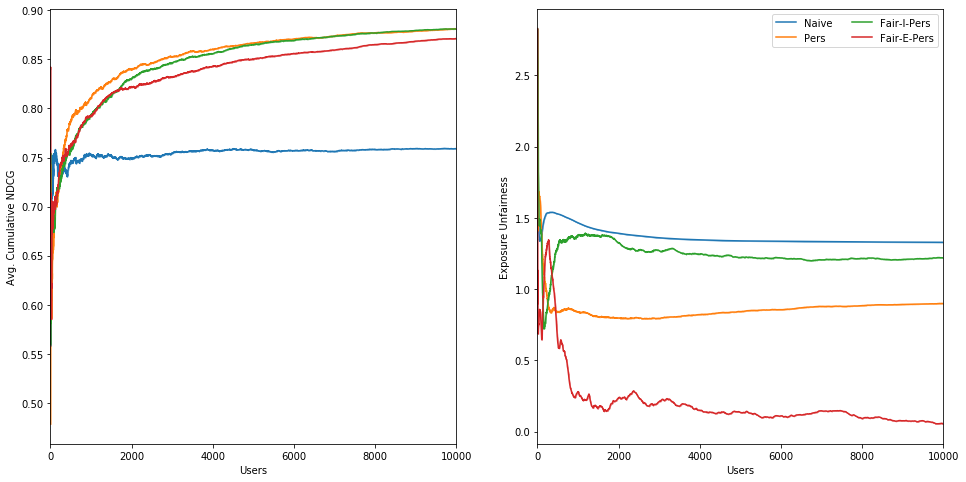

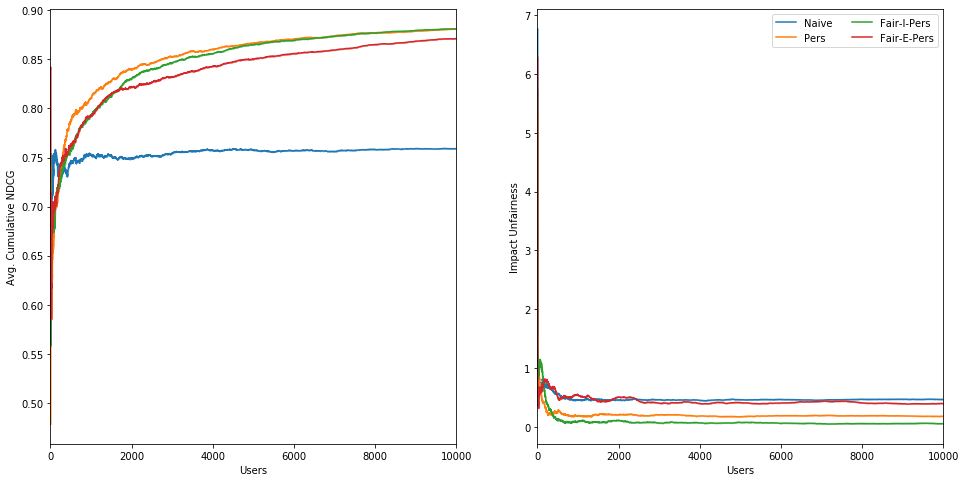

In [31]:
ranking_methods = ["Naive","Pers","Fair-I-Pers", "Fair-E-Pers"]
iterations = 10000
_, _, groups = load_movie_data_saved(MOVIE_RATING_FILE)
items = []
for i, g in enumerate(groups):
    items.append(Movie(i, g))
popularity = np.ones(len(items))
G = assign_groups(items)

#The User Generator loads the relevance Matrix from File
user_generator = Usersampler(DATA_SET=1, BI_LEFT=0.5, MOVIE_RATING_FILE = MOVIE_RATING_FILE)

data = {"prop": np.zeros((len(ranking_methods), iterations, len(G))),
            "clicks": np.zeros((len(ranking_methods), iterations, len(G))), "rel": np.zeros((len(ranking_methods), iterations, len(G))),
            "true_rel": np.zeros((len(ranking_methods), iterations, len(G))), "NDCG": np.zeros((len(ranking_methods), iterations))}

#Run trial for each Ranking method and add to data dict
for i, method in enumerate(ranking_methods):
    data_hist = trial(items, popularity, G, method, user_generator, iterations, DATA_SET=1, MOVIE_RATING_FILE=MOVIE_RATING_FILE)
    for key, value in data_hist.items():
        data[key][i] = value

#Get Unfairness based on Collect Data
overall_fairness = get_unfairness(data, G)

plot_unfairness_and_NDCG(data["NDCG"], overall_fairness, ranking_methods, G)